# Pythonで信号処理をやってみよう

wavファイルを読み込んで、プロットするまでのデモ。

In [1]:
# import modules
import numpy as np
import wave
import matplotlib.pyplot as plt
import scipy.signal
from scipy import fftpack as fft

wavファイルは、waveモジュールで読み込みます。  
公式リファレンスは[こちら](https://docs.python.org/ja/3/library/wave.html)。

このモジュールの少々厄介な点が、wavのデータをバイナリで返して来ること。  
なので、バイナリ→フロートの変換が必要になります。

In [2]:
wave_path = "/Users/watakabe/Desktop/pink_200ms.wav" # 好きなwavファイルのパスに書き換えてください。

with wave.open(wave_path, 'rb') as wr:
    
    params = wr.getparams()
    frames = wr.readframes(params[3])

# print(frames)

このように、wavファイルを読み込むだけだと、16進数の数値が返ってくるので  
10進数のfloatに変換する必要があります。

変換の際、wavファイルに設定されている量子化ビット数により、条件分けする必要があります。  
wavファイルのヘッダには以下のパラメータが設定されています。

In [3]:
print(params)

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=9600, comptype='NONE', compname='not compressed')


In [4]:
nchannels = params[0]
sampwidth = params[1]
fs = params[2]
nframes = params[3]

if sampwidth==2:
    data = np.frombuffer(frames, dtype=np.int16) / (16 ** sampwidth) ** 2 / 2
elif sampwidth == 3:
    a8 = np.frombuffer(frames, dtype=np.uint8) # とりあえず1数値毎に見る。
    temp = np.zeros((nframes*nchannels, 4), np.uint8)
    temp[:,1: ] = np.reshape(a8, [-1, 3])
    data = temp.view(np.int32) /(16 ** 4) ** 2 / 2
elif sampwidth == 4:
    data = np.frombuffer(frames, dtype=np.int32) / (16 ** sampwidth) ** 2 / 2

3バイト(24ビット)のときは少しめんどくさいです。  
24ビットはハイレゾ音源の量子化ビット数です。

これで`data`にwavデータが書き込まれました。

In [5]:
print(data)

[-0.02887726 -0.02017975 -0.04798889 ... -0.10687256 -0.08483887
 -0.05899811]


numpy配列のプロットにはmatplotを用います。  

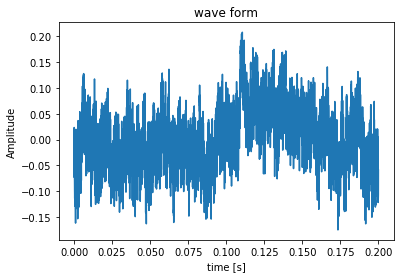

In [6]:
t = np.linspace(0, nframes/fs, nframes)
plt.plot(t, data)
plt.xlabel("time [s]")
plt.ylabel("Amplitude")
plt.title("wave form")
plt.show()

### パワースペクトルをプロットする。

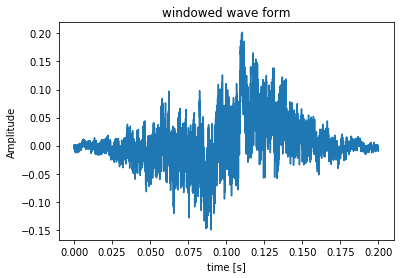

In [7]:
# FFTするために、データの両端が0になるよう窓がけしましょう。
window = scipy.signal.hamming(nframes)
data_windowed = window * data

plt.plot(t, data_windowed)
plt.xlabel("time [s]")
plt.ylabel("Amplitude")
plt.title("windowed wave form")
plt.show()

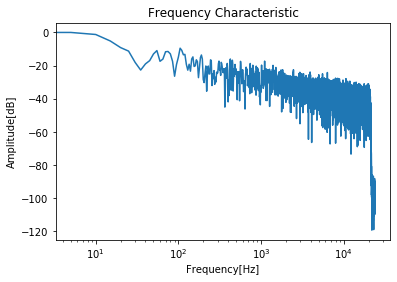

In [8]:
dataF = np.abs(fft.fft(data_windowed))
freq = fft.fftfreq(dataF.size, d=1/fs) # プロットするための周波数軸の配列

# FFTすると負の周波数（折り返し周波数）が生まれるので、実際にプロットするのは前半半分です。
plt.plot(freq[:nframes//2], 20*np.log10(dataF/np.max(dataF))[:nframes//2]) # 20log10()する
plt.xscale("log") # x軸を対数軸に
plt.xlabel("Frequency[Hz]")
plt.ylabel("Amplitude[dB]")
plt.title("Frequency Characteristic")
plt.show()